reference: https://colab.research.google.com/drive/1_Y94r57i-A_TPXpgp7sgn2m4Mu2hlWE4#scrollTo=9WlSAs9NfqTE 

In [1]:
import SimpleITK as sitk 
import matplotlib
import gui
import os
import registration_gui as rgui
import utilities

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

In [2]:
# chest image path
chest_dpath = r'data\chestctdata'
chest_fixed_path = r'data\chestctdata\01_Fixed.mhd'
chest_moving_path = r'data\chestctdata\01_Moving.mhd'



In [3]:
# lung image path 
lung_dpath = r'data\lungMasks'
lung_fixed_path = r'data\lungMasks\01_Fixed.mhd'
lung_moving_path = r'data\lungMasks\01_Moving.mhd'

### Image preprocessing

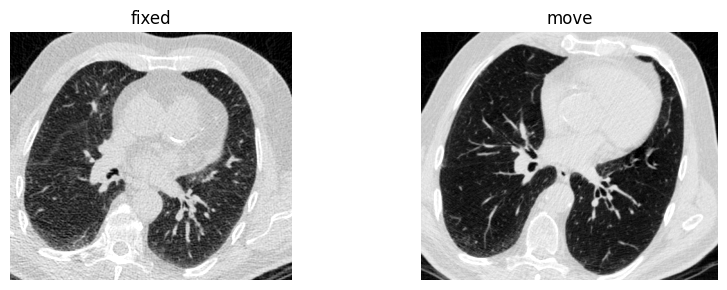

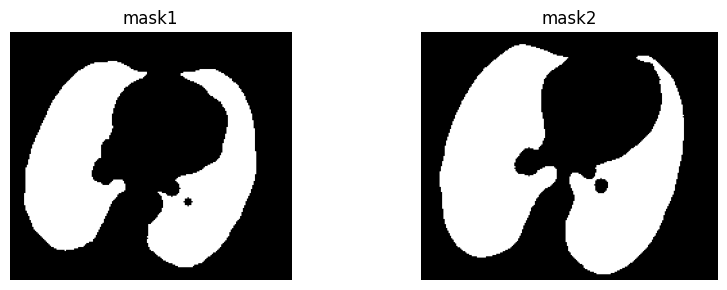

In [4]:
# Display chest images
chest_fixed = sitk.ReadImage(chest_fixed_path)
chest_moving = sitk.ReadImage(chest_moving_path)

# display lung masks 
lung_fixed = sitk.ReadImage(lung_fixed_path)
lung_moving = sitk.ReadImage(lung_moving_path)

# display images
gui.MultiImageDisplay(image_list=[chest_fixed,chest_moving],
                      title_list=['fixed','move'],
                      figure_size=(9,3))

gui.MultiImageDisplay(image_list=[lung_fixed,lung_moving],
                      title_list=['mask1','mask2'],
                      figure_size=(9,3))

In [5]:
print(chest_fixed)

Image (000001D07AE37820)
  RTTI typeinfo:   class itk::Image<short,3>
  Reference Count: 1
  Modified Time: 1857
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 1828
  UpdateMTime: 1853
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [418, 368, 323]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [418, 368, 323]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [418, 368, 323]
  Spacing: [0.683594, 0.683594, 0.7]
  Origin: [0, 0, 0]
  Direction: 
1 0 0
0 1 0
0 0 1

  IndexToPointMatrix: 
0.683594 0 0
0 0.683594 0
0 0 0.7

  PointToIndexMatrix: 
1.46286 0 0
0 1.46286 0
0 0 1.42857

  Inverse Direction: 
1 0 0
0 1 0
0 0 1

  PixelContainer: 
    ImportImageContainer (000001D07A49C5E0)
      RTTI typeinfo:   class itk::ImportImageContainer<unsigned __int64,short>
 

In [6]:
print(chest_moving)

Image (000001D07AE37DC0)
  RTTI typeinfo:   class itk::Image<short,3>
  Reference Count: 1
  Modified Time: 2095
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 2066
  UpdateMTime: 2091
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [462, 386, 412]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [462, 386, 412]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [462, 386, 412]
  Spacing: [0.679688, 0.679688, 0.7]
  Origin: [0, 0, 0]
  Direction: 
1 0 0
0 1 0
0 0 1

  IndexToPointMatrix: 
0.679688 0 0
0 0.679688 0
0 0 0.7

  PointToIndexMatrix: 
1.47126 0 0
0 1.47126 0
0 0 1.42857

  Inverse Direction: 
1 0 0
0 1 0
0 0 1

  PixelContainer: 
    ImportImageContainer (000001D07A49C260)
      RTTI typeinfo:   class itk::ImportImageContainer<unsigned __int64,short>
 

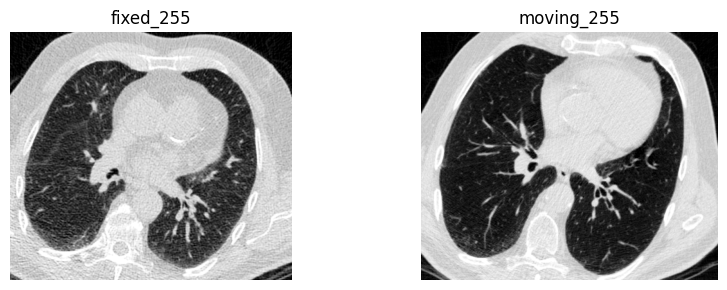

In [7]:
# prepare data for processing 

# for chest fixed image the intensity is : −1020 – 385
fixed_255 = sitk.Cast(sitk.IntensityWindowing(chest_fixed, windowMinimum=-1020, windowMaximum=385,
                        outputMinimum=0.0, outputMaximum=255.0), sitk.sitkUInt8)

# for chest moving image the intensity is : −1006 – 300
moving_255 = sitk.Cast(sitk.IntensityWindowing(chest_moving, windowMinimum=-1006, windowMaximum=300,
                                             outputMinimum=0.0, outputMaximum=255.0), sitk.sitkUInt8)

gui.MultiImageDisplay(image_list = [fixed_255, moving_255],
                      title_list = ['fixed_255', 'moving_255'],
                      figure_size=(9,3))

In [8]:
def make_isotropic(image, interpolator = sitk.sitkLinear):
    '''
    Resample an image to isotropic pixels (using smallest spacing from original) and save to file. Many file formats
    (jpg, png,...) expect the pixels to be isotropic. By default the function uses a linear interpolator. For
    label images one should use the sitkNearestNeighbor interpolator so as not to introduce non-existant labels.
    '''
    original_spacing = image.GetSpacing()
    # Image is already isotropic, just return a copy
    if all(spc == original_spacing[0] for spc in original_spacing):
        return sitk.Image(image)
    # Make image isotropic via resampling
    original_size = image.GetSize()
    min_spacing = min(original_spacing)
    new_spacing = [min_spacing]*image.GetDimension()
    new_size = [int(round(osz*ospc/min_spacing)) for osz,ospc in zip(original_size, original_spacing)]
    return sitk.Resample(image, new_size, sitk.Transform(), interpolator,
                         image.GetOrigin(), new_spacing, image.GetDirection(), 0,
                         image.GetPixelID())

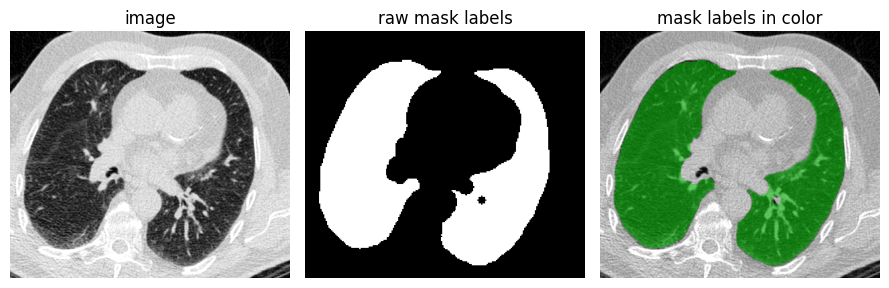

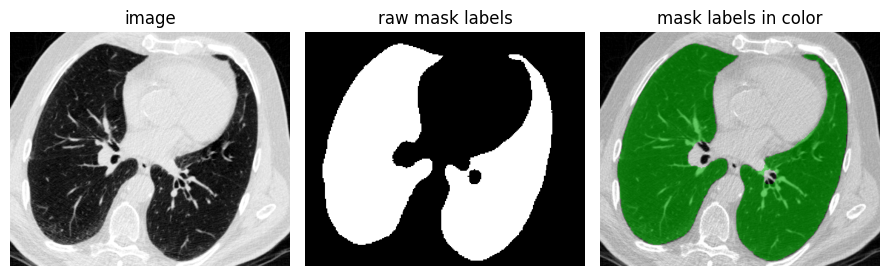

In [9]:
# iso fixed images 
fixed_255_iso = make_isotropic(fixed_255)
fixed_mask = make_isotropic(lung_fixed)


# iso moving image 
moving_255_iso = make_isotropic(moving_255)
moving_mask = make_isotropic(lung_moving)


# display overlay of mask 
gui.MultiImageDisplay(image_list = [fixed_255_iso, fixed_mask, sitk.LabelOverlay(fixed_255_iso, fixed_mask)],
                      title_list = ['image', 'raw mask labels', 'mask labels in color'],
                      figure_size=(9,3), shared_slider=True)

gui.MultiImageDisplay(image_list = [moving_255_iso, moving_mask, sitk.LabelOverlay(moving_255_iso, moving_mask)],
                      title_list = ['image', 'raw mask labels', 'mask labels in color'],
                      figure_size=(9,3), shared_slider=True)



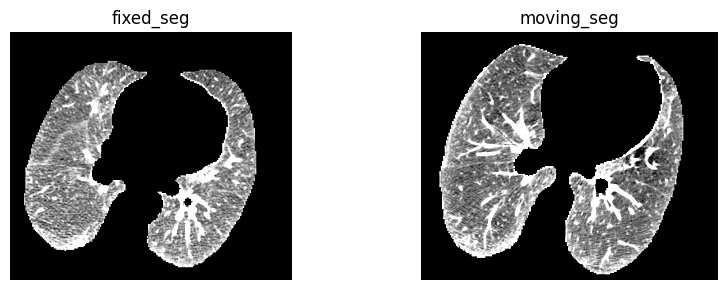

In [10]:
fixed_image = fixed_255_iso*fixed_mask
moving_image = moving_255_iso*moving_mask

# display final segmentation 
gui.MultiImageDisplay(image_list = [fixed_image, moving_image],
                      title_list = ['fixed_seg', 'moving_seg'],
                      figure_size=(9,3))

In [11]:
print(fixed_image.GetSpacing())
print(moving_image.GetSpacing())

(0.683594, 0.683594, 0.683594)
(0.679688, 0.679688, 0.679688)


(0.683594, 0.683594, 0.683594)
(0.679688, 0.679688, 0.679688)
(0.683594, 0.683594, 0.683594)


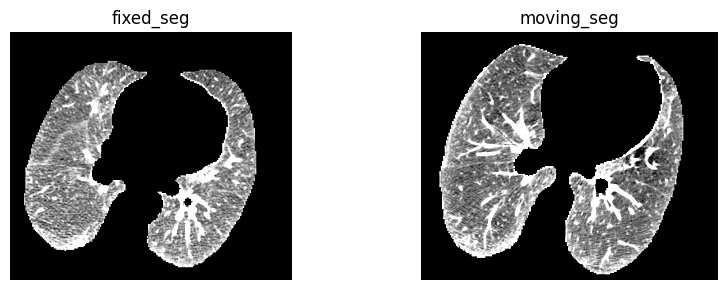

In [12]:
#
print(fixed_image.GetSpacing())
print(moving_image.GetSpacing())
moving_image.SetSpacing(fixed_mask.GetSpacing())
print(moving_image.GetSpacing())
moving_image = make_isotropic(moving_image)
gui.MultiImageDisplay(image_list = [fixed_image, moving_image],
                      title_list = ['fixed_seg', 'moving_seg'],
                      figure_size=(9,3))

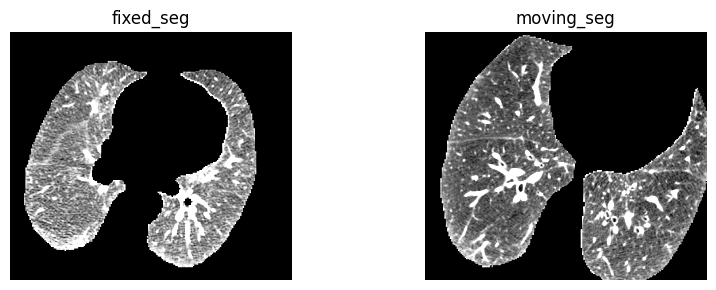

In [13]:
moving_image = sitk.Resample(moving_image, fixed_image, sitk.Transform(), sitk.sitkLinear, 0, moving_image.GetPixelID())
gui.MultiImageDisplay(image_list = [fixed_image, moving_image],
                      title_list = ['fixed_seg', 'moving_seg'],
                      figure_size=(9,3))

combine two images

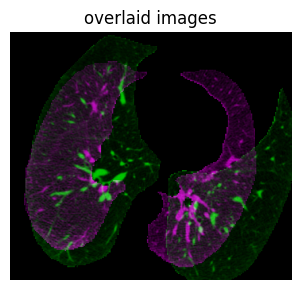

In [14]:
# Combine fixed and moving images
# fixed_image = make_isotropic(fixed_image)
# moving_image = make_isotropic(moving_image)
combined_image = sitk.Cast(sitk.Compose(fixed_image, moving_image, fixed_image), sitk.sitkVectorUInt8)

gui.MultiImageDisplay(image_list = [combined_image],
                      title_list = ['overlaid images'],
                      figure_size=(9,3))

### Image Registration 

### Overlay Images